In [79]:
import os 
import tensorflow as tf
from tabulate import tabulate
from collections import defaultdict
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from imagehash import average_hash
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils import resample


from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import AUC, Precision, Recall



In [2]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
print(os.listdir(base_dir) if os.path.exists else "path is not found")
print(f"gpu is avaialble",tf.config.list_physical_devices('GPU'))

['val', '.DS_Store', 'test', 'train']
gpu is avaialble [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_dir = os.path.join(base_dir,"train")
val_dir = os.path.join(base_dir,"val")
test_dir = os.path.join(base_dir,"test")

In [4]:
# seeing the data set distribution in table
def no_of_images(directory):
    count=defaultdict(int)
    for root,dirs,files in os.walk(directory):
        class_name= os.path.basename(root)
        img_count = sum(file.lower().endswith(('.jpg','.png','.jpeg')) for file in files)
        if img_count>0:
            count[class_name] = img_count
    return dict(count)

train_counts = no_of_images(train_dir)
val_counts = no_of_images(val_dir)
test_counts = no_of_images(test_dir)

table =[['Train',train_counts.get('NORMAL',0),train_counts.get('PNEUMONIA',0),sum(train_counts.values())],
        ['val',val_counts.get('NORMAL',0),val_counts.get('PNEUMONIA',0),sum(val_counts.values())],
       ['Test',test_counts.get('NORMAL',0),test_counts.get('PNEUMONIA',0),sum(test_counts.values())],
       ["Total",train_counts.get('NORMAL',0)+val_counts.get('NORMAL',0)+test_counts.get('NORMAL',0),
        train_counts.get('PNEUMONIA',0)+val_counts.get('PNEUMONIA',0)+test_counts.get('PNEUMONIA',0),
         sum(train_counts.values())+sum(val_counts.values())+sum(test_counts.values())]]

print(tabulate(table,tablefmt = 'grid',headers=['Split','Normal','Pneumonia','Total'],numalign = 'center'))

+---------+----------+-------------+---------+
| Split   |  Normal  |  Pneumonia  |  Total  |
+=========+==========+=============+=========+
| Train   |   1341   |    3875     |  5216   |
+---------+----------+-------------+---------+
| val     |    8     |      8      |   16    |
+---------+----------+-------------+---------+
| Test    |   234    |     390     |   624   |
+---------+----------+-------------+---------+
| Total   |   1583   |    4273     |  5856   |
+---------+----------+-------------+---------+


### Dataset Distribution Analysis

The dataset shows significant class imbalance and split distribution issues:

1. **Class Imbalance**:
   - **Pneumonia cases dominate** (4,273) vs Normal (1,583)

2. **Split Problems**:
   - **Validation set is critically small** (only 16 images)
     - 8 Normal + 8 Pneumonia samples
     - Far below the recommended 10-20% of total data

3. **Training Implications**:
   - The tiny validation set **cannot provide reliable metrics**
   - High risk of **overfitting** with no meaningful validation
   - Model performance claims will be **statistically unreliable**

4. **Recommended Actions**:
   - **Redistribute splits** to get at least 500-1000 validation images
   - Consider **stratified k-fold cross-validation** instead of fixed splits
   - Apply **strong regularization** (dropout, L2, early stopping)
   - Use **class weights** to handle the imbalance

In [5]:
## As data set is imbalanced now combine all the images from the training testing and validation then split them by maintaining class balance

all_images=[]
all_labels=[]

for split in ['train','val','test'] :
    for class_name in ['NORMAL','PNEUMONIA'] :
        path = os.path.join(base_dir,split,class_name)
        if os.path.exists(path):
            for img_file in os.listdir(path):
                if img_file.lower().endswith(('.jpg','.jpeg','.png')):
                    img_path = os.path.join(path,img_file)
                    all_images.append(img_path)
                    all_labels.append(class_name)

print('Total images collected are:',len(all_images))


#splitting the data with 70-15-15 for train-val-test respectively

x_train,x_temp,y_train,y_temp = train_test_split(
    all_images,all_labels,
    test_size = 0.3,
    random_state = 42,
    stratify= all_labels
     )

x_val,x_test,y_val,y_test = train_test_split(
    x_temp,y_temp,
    stratify = y_temp,
    random_state = 42,
    test_size = 0.5
)

#copying data to the new location 
new_dest_dir='data_redistributed_stratified'
os.makedirs(new_dest_dir,exist_ok = True)

def copy_to_new_structure(split,images,labels):
    for images,labels in tqdm(zip(images,labels), total=len(images), desc=f"Copying {split}"):
        folder_path = os.path.join(new_dest_dir,split,labels)
        os.makedirs(folder_path,exist_ok = True)
        shutil.copy(images,folder_path)


copy_to_new_structure('train',x_train,y_train)
copy_to_new_structure('val', x_val, y_val)
copy_to_new_structure('test', x_test, y_test)

Total images collected are: 5856


Copying test: 100%|██████████| 879/879 [00:06<00:00, 131.37it/s]


In [6]:
#new base directory
new_base_dir= '/kaggle/working/data_redistributed_stratified'

new_train_dir = os.path.join(new_base_dir,"train")
new_val_dir = os.path.join(new_base_dir,"val")
new_test_dir = os.path.join(new_base_dir,"test")

In [7]:
#visualizing the distribution of the new dataset


def no_of_images(directory):
    count=defaultdict(int)
    for root,dirs,files in os.walk(directory):
        class_name= os.path.basename(root)
        img_count = sum(file.lower().endswith(('.jpg','.png','.jpeg')) for file in files)
        if img_count>0:
            count[class_name] = img_count
    return dict(count)

train_counts = no_of_images(new_train_dir)
val_counts = no_of_images(new_val_dir)
test_counts = no_of_images(new_test_dir)

table =[['Train',train_counts.get('NORMAL',0),train_counts.get('PNEUMONIA',0),sum(train_counts.values())],
        ['val',val_counts.get('NORMAL',0),val_counts.get('PNEUMONIA',0),sum(val_counts.values())],
       ['Test',test_counts.get('NORMAL',0),test_counts.get('PNEUMONIA',0),sum(test_counts.values())],
       ["Total",train_counts.get('NORMAL',0)+val_counts.get('NORMAL',0)+test_counts.get('NORMAL',0),
        train_counts.get('PNEUMONIA',0)+val_counts.get('PNEUMONIA',0)+test_counts.get('PNEUMONIA',0),
         sum(train_counts.values())+sum(val_counts.values())+sum(test_counts.values())]]

print(tabulate(table,tablefmt = 'grid',headers=['Split','Normal','Pneumonia','Total'],numalign = 'center'))

+---------+----------+-------------+---------+
| Split   |  Normal  |  Pneumonia  |  Total  |
+=========+==========+=============+=========+
| Train   |   1108   |    2991     |  4099   |
+---------+----------+-------------+---------+
| val     |   237    |     641     |   878   |
+---------+----------+-------------+---------+
| Test    |   238    |     641     |   879   |
+---------+----------+-------------+---------+
| Total   |   1583   |    4273     |  5856   |
+---------+----------+-------------+---------+


In [8]:
#checking for the duplicate values in the splits to avoid the data leakage in data splits

def get_hashes(directory):
    """"This function will give the hashes list which consists of average hashes of all images"""
    hashes=[]
    for root,_,files in os.walk(directory):
        class_name = os.path.basename(root)
        for file in files:
            if file.lower().endswith(('.jpg','.jpeg','.png')):
                try:
                    
                    image_path = os.path.join(directory,class_name,file)
                    with Image.open(image_path) as img:
                        hashes.append(average_hash(img))
                except Exception as e:
                    print(f"Error processing: {image_path}:{str(e)}")
    return hashes


train_hashes = get_hashes(new_train_dir)
val_hashes = get_hashes(new_val_dir)
test_hashes = get_hashes(new_test_dir)
print(train_hashes[0])


# Find duplicates
duplicates_tr_v = set(train_hashes) & set(val_hashes)
print(f"Number of duplicate images between train and validation found: {len(duplicates_tr_v)}")
duplicates_tr_t = set(train_hashes) & set(test_hashes)
print(f"Number of duplicate images between train and test found: {len(duplicates_tr_t)}")
duplicates_v_t = set(val_hashes) & set(test_hashes)
print(f"Number of duplicate images between validation and test found: {len(duplicates_v_t)}")

7e7e5e5e1e1c7e7e
Number of duplicate images between train and validation found: 53
Number of duplicate images between train and test found: 55
Number of duplicate images between validation and test found: 21


In [9]:
#we have identified the duplicates in the given splits so now we move them to the train data from the val and test data 
unique_hashes = set()

#first the process the training data and copy the hashes of the training data to unique_hashes set
for class_name in ['NORMAL','PNEUMONIA']:
    class_path = os.path.join(new_train_dir,class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path,img_file)
        try:
            with Image.open(img_path) as img_obj:
                unique_hashes.add(str(average_hash(img_obj)))
        except: 
            continue
#now process the val and test data and move duplicates from them to the train data
for split in [new_val_dir,new_test_dir]:
    for class_name in ['NORMAL','PNEUMONIA']:
        class_path = os.path.join(split,class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path,img_file)
            try:
                with Image.open(img_path) as img_obj:
                    hash = str(average_hash(img_obj))
                    unique_hashes.add(hash) if hash not in unique_hashes else shutil.move(img_path,os.path.join(new_train_dir,class_name))
            except: 
                continue
            
    

In [10]:
def no_of_images(directory):
    count=defaultdict(int)
    for root,dirs,files in os.walk(directory):
        class_name= os.path.basename(root)
        img_count = sum(file.lower().endswith(('.jpg','.png','.jpeg')) for file in files)
        if img_count>0:
            count[class_name] = img_count
    return dict(count)

train_counts = no_of_images(new_train_dir)
val_counts = no_of_images(new_val_dir)
test_counts = no_of_images(new_test_dir)

table =[['Train',train_counts.get('NORMAL',0),train_counts.get('PNEUMONIA',0),sum(train_counts.values())],
        ['val',val_counts.get('NORMAL',0),val_counts.get('PNEUMONIA',0),sum(val_counts.values())],
       ['Test',test_counts.get('NORMAL',0),test_counts.get('PNEUMONIA',0),sum(test_counts.values())],
       ["Total",train_counts.get('NORMAL',0)+val_counts.get('NORMAL',0)+test_counts.get('NORMAL',0),
        train_counts.get('PNEUMONIA',0)+val_counts.get('PNEUMONIA',0)+test_counts.get('PNEUMONIA',0),
         sum(train_counts.values())+sum(val_counts.values())+sum(test_counts.values())]]

print(tabulate(table,tablefmt = 'grid',headers=['Split','Normal','Pneumonia','Total'],numalign = 'center'))

+---------+----------+-------------+---------+
| Split   |  Normal  |  Pneumonia  |  Total  |
+=========+==========+=============+=========+
| Train   |   1167   |    3081     |  4248   |
+---------+----------+-------------+---------+
| val     |   212    |     595     |   807   |
+---------+----------+-------------+---------+
| Test    |   204    |     597     |   801   |
+---------+----------+-------------+---------+
| Total   |   1583   |    4273     |  5856   |
+---------+----------+-------------+---------+


In [11]:
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

print("Training images:", count_images(new_train_dir))
print("Validation images:", count_images(new_val_dir))
print("Test images:", count_images(new_test_dir))

# # Get the new distributions
# print('Train:', get_class_distribution(train_dir))
# print('Validation:',get_class_distribution(val_dir))
# print('Test:',get_class_distribution(test_dir))

Training images: 4248
Validation images: 807
Test images: 801


# Image Analysis Summary

### Basic Statistics
- **Average Image Size**: 1126.84 (width) X 1465.32 (height) pixels  
- **Pixel Value Distribution**:  
  - **Mean**: 124.6  
  - **Standard Deviation**: 63.4  

### Observations
- The histogram shows pixel values ranging from 0 to 255, with counts distributed across intensities.  
- The mean pixel value (124.6) suggests a balanced distribution, while the standard deviation (63.4) indicates moderate variability in pixel intensities.  

### Potential Insights
- The image dimensions are relatively large, which may imply high resolution or detailed content.  
- The pixel value distribution could be further analyzed to identify dominant intensity ranges or patterns.


In [13]:
#seeing data distribution and creating distribution directories

print(train_counts,val_counts,test_counts)

{'NORMAL': 1167, 'PNEUMONIA': 3081} {'NORMAL': 212, 'PNEUMONIA': 595} {'NORMAL': 204, 'PNEUMONIA': 597}


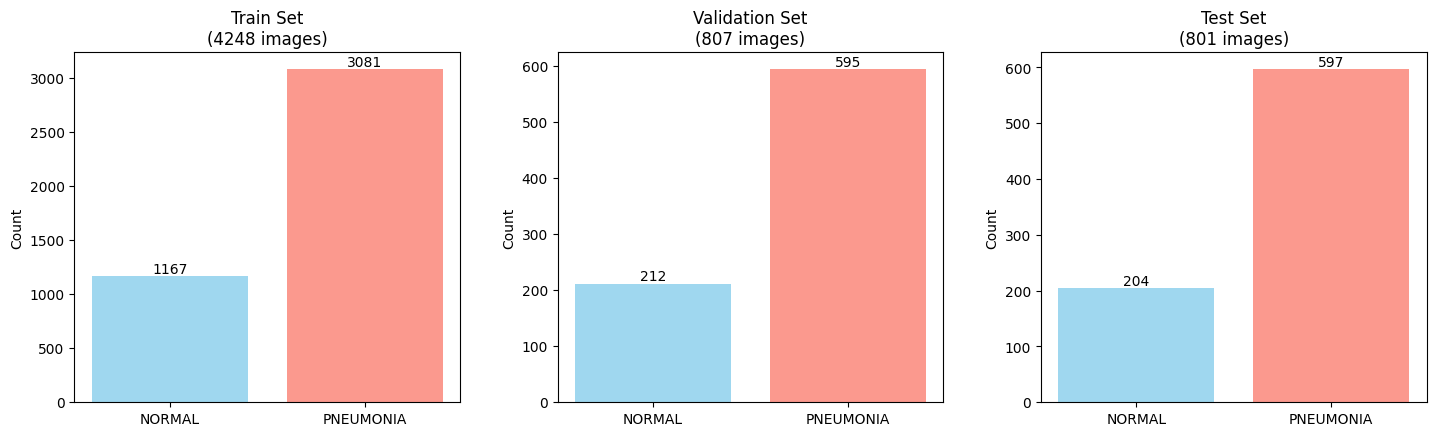

In [14]:
# Class Distribution Visualization 
plt.figure(figsize=(15, 5))

# Create subplots
for i, (name, dist) in enumerate(zip(['Train', 'Validation', 'Test'], 
                                   [train_counts,val_counts,test_counts]), 1):
    plt.subplot(1, 3, i)
    bars = plt.bar(dist.keys(), dist.values(), color=['skyblue', 'salmon'], alpha=0.8)
    plt.title(f'{name} Set\n({sum(dist.values())} images)')
    plt.ylabel('Count')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout(pad=3.0)  # Add extra padding between subplots
plt.show()

### Traning Phase Frist train the model using the HOG+RANDOM FOREST CLASSIFIER

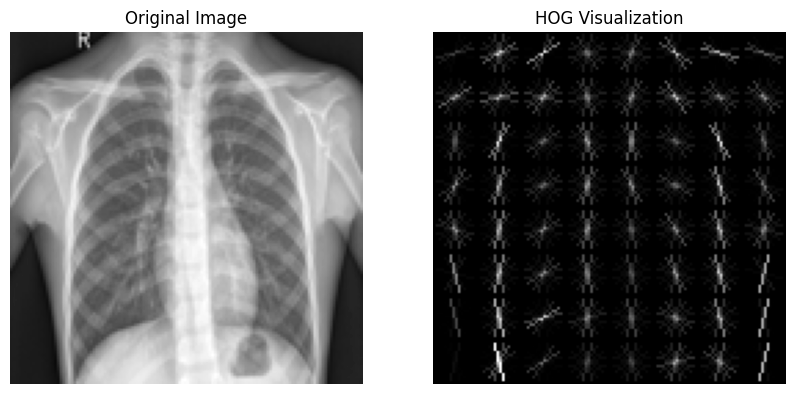

<class 'numpy.ndarray'>


In [24]:
# SAMPLE  OF HOW HOG EXTRACT THE ORIGINAL IMAGE

def visualize_hog(image_path, resize_dim=(128, 128)):
    # Load and preprocess image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize(resize_dim)
    img_array = np.array(img)

    # Extract HOG features with visualization enabled
    fd, hog_image = hog(
        img_array,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        block_norm='L2-Hys'
    )

    # Plot original and HOG image side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('HOG Visualization')
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.show()
    print(type(fd))
visualize_hog(os.path.join(new_train_dir,'NORMAL','IM-0001-0001.jpeg'))



In [31]:
def extract_hog(img_path,reduce_dimension = (128,128)):
    img = Image.open(img_path).convert('L')
    img = img.resize(reduce_dimension)
    img = np.array(img)


    features,hog_img = hog(
        img,
        orientations = 8,
        pixels_per_cell = (16,16),
        cells_per_block = (1,1),
        visualize = True
    )
    return features


def img_to_hog_img(directory):
    x=[]
    y=[]
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory,class_name)
        if not  os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path,img_file)
            hog_array= extract_hog(img_path)
            x.append(hog_array)
            y.append(0 if class_name == 'NORMAL' else 1)

    return np.array(x),np.array(y)

#building training and testing data from the data we get from the img_to_hog_img function
print(new_train_dir,new_test_dir)

x_train,y_train = img_to_hog_img(new_train_dir)

x_test,y_test = img_to_hog_img(new_test_dir)         


/kaggle/working/data_redistributed_stratified/train /kaggle/working/data_redistributed_stratified/test


`HOG Feature Extraction for Classical ML`

**Key Components:**
1. `extract_hog_features()` Function:
   - Converts images to grayscale (`'L'` mode)
   - Resizes to consistent dimensions (default 128×128)
   - Computes Histogram of Oriented Gradients (HOG) features with:
     
2. `prepare_classical_ml_data()` Function:
   - Processes directory structure to:
     - Extract HOG features per image
     - Assign labels (0 for `NORMAL`, 1 for `PNEUMONIA`)
   - Returns feature matrix `X` and label vector `y`

`HOG Parameters Explained:`
| Parameter          | Value    | Effect                                                                 |
|--------------------|----------|-----------------------------------------------------------------------|
| `orientations`     | 8        | Number of gradient orientation bins (trade-off between detail and dimensionality) |
| `pixels_per_cell`  | (16,16)  | Smaller values capture finer details but increase feature size        |
| `cells_per_block`  | (1,1)    | No block normalization (simpler features)                             |


`Key Advantages for Pneumonia Detection`

1. **Shape and Texture Sensitivity**
   - HOG excels at capturing **edge patterns** and **local shape information**
   - Critical for detecting:
     - Pulmonary infiltrates (pneumonia)
     - Alveolar patterns
     - Bronchial wall thickening

2. **Illumination Invariance**
   - Normalizes gradients → robust to:
     - X-ray exposure variations
     - Scanner differences
     - Contrast fluctuations

3. **Dimensionality Efficiency**
    - The configuration (512 features) is:
     - **Rich enough**: Captures pulmonary pathology signatures
     - **Compact enough**: Avoids curse of dimensionality vs. raw pixels (16,384 for 128×128)

4. **Clinical Interpretability**
   - Visualizing HOG features shows:
     - Where the model detects important edges

In [33]:
#Loading Rf and training model using the  random forest classifier

RandomForest = RandomForestClassifier(n_estimators = 100,random_state = 42)
RandomForest.fit(x_train,y_train)
#making predictions
y_pred = RandomForest.predict(x_test)


In [34]:
print(f"The accuracy of the model is {accuracy_score(y_test,y_pred)}")

The accuracy of the model is 0.9425717852684145


### NOW TRAINING THE MODEL USING THE CUSTOM CNN MODEL 
-  AS THE PNEUMONIA EXAMPLES IN THE DATA DOMINATES THE NORMAL EXAMPLES WE HAVE TO DO DATA AUGUMENTATION AND CLASS WEIGHTS BALANCING TECHNIQUES


In [90]:
#DATA AUGUMENTATION
img_height, img_width = 320, 320 # decided that based on the statistics we produced above
batch_size = 32
input_shape = (img_height, img_width, 1)

train_aug_normal_gen = ImageDataGenerator(
      rescale=1./255,
    rotation_range=8, 
    width_shift_range=0.05,  
    height_shift_range=0.05,
    zoom_range=0.05,  
    shear_range = 0.05,
    brightness_range=[0.95, 1.05],  
    horizontal_flip=True,
    fill_mode='nearest'
    
)

train_aug_pneumonia_and_val_and_test_gen = ImageDataGenerator(rescale = 1./255)

train_normal_generator = train_aug_normal_gen.flow_from_directory(
    new_train_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    classes = ['NORMAL'],
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=42
    
)

train_pneumonia_generator = train_aug_pneumonia_and_val_and_test_gen.flow_from_directory(
    new_train_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    classes = ['PNEUMONIA'],
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed = 42
)
def combined_generator(gen1, gen2):
    while True:
        x1, y1 = next(gen1)  # NORMAL
        x2, y2 = next(gen2)  # PNEUMONIA

        # Manually fix labels because each generator thinks its class is 0
        y1_fixed = np.tile([1, 0], (len(y1), 1))  # NORMAL → [1, 0]
        y2_fixed = np.tile([0, 1], (len(y2), 1))  # PNEUMONIA → [0, 1]

        # Combine batches
        x_combined = np.concatenate([x1, x2], axis=0)
        y_combined = np.concatenate([y1_fixed, y2_fixed], axis=0)

        # Shuffle
        indices = np.arange(x_combined.shape[0])
        np.random.shuffle(indices)
        x_combined = x_combined[indices]
        y_combined = y_combined[indices]

        # # ✅ Debug print: Check label counts after shuffling
        # label_indices = np.argmax(y_combined, axis=1)
        # normal_count = np.sum(label_indices == 0)
        # pneumonia_count = np.sum(label_indices == 1)
        # print(f"🔍 After shuffle → NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}")

        yield x_combined, y_combined



train_generator = combined_generator(train_normal_generator,train_pneumonia_generator)

val_generator = train_aug_pneumonia_and_val_and_test_gen.flow_from_directory(
    new_val_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
    
)


# --------------------------
# 1. Evaluation Generator
# --------------------------
test_eval_generator = train_aug_pneumonia_and_val_and_test_gen.flow_from_directory(
     new_test_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False                      # Important for matching predictions to filenames
)

# --------------------------
# 2. Visualization Generator
# --------------------------
test_vis_generator = train_aug_pneumonia_and_val_and_test_gen.flow_from_directory(
     new_test_dir,
    target_size = (img_height,img_width),
    batch_size = 1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 1167 images belonging to 1 classes.
Found 3081 images belonging to 1 classes.
Found 807 images belonging to 2 classes.
Found 801 images belonging to 2 classes.
Found 801 images belonging to 2 classes.


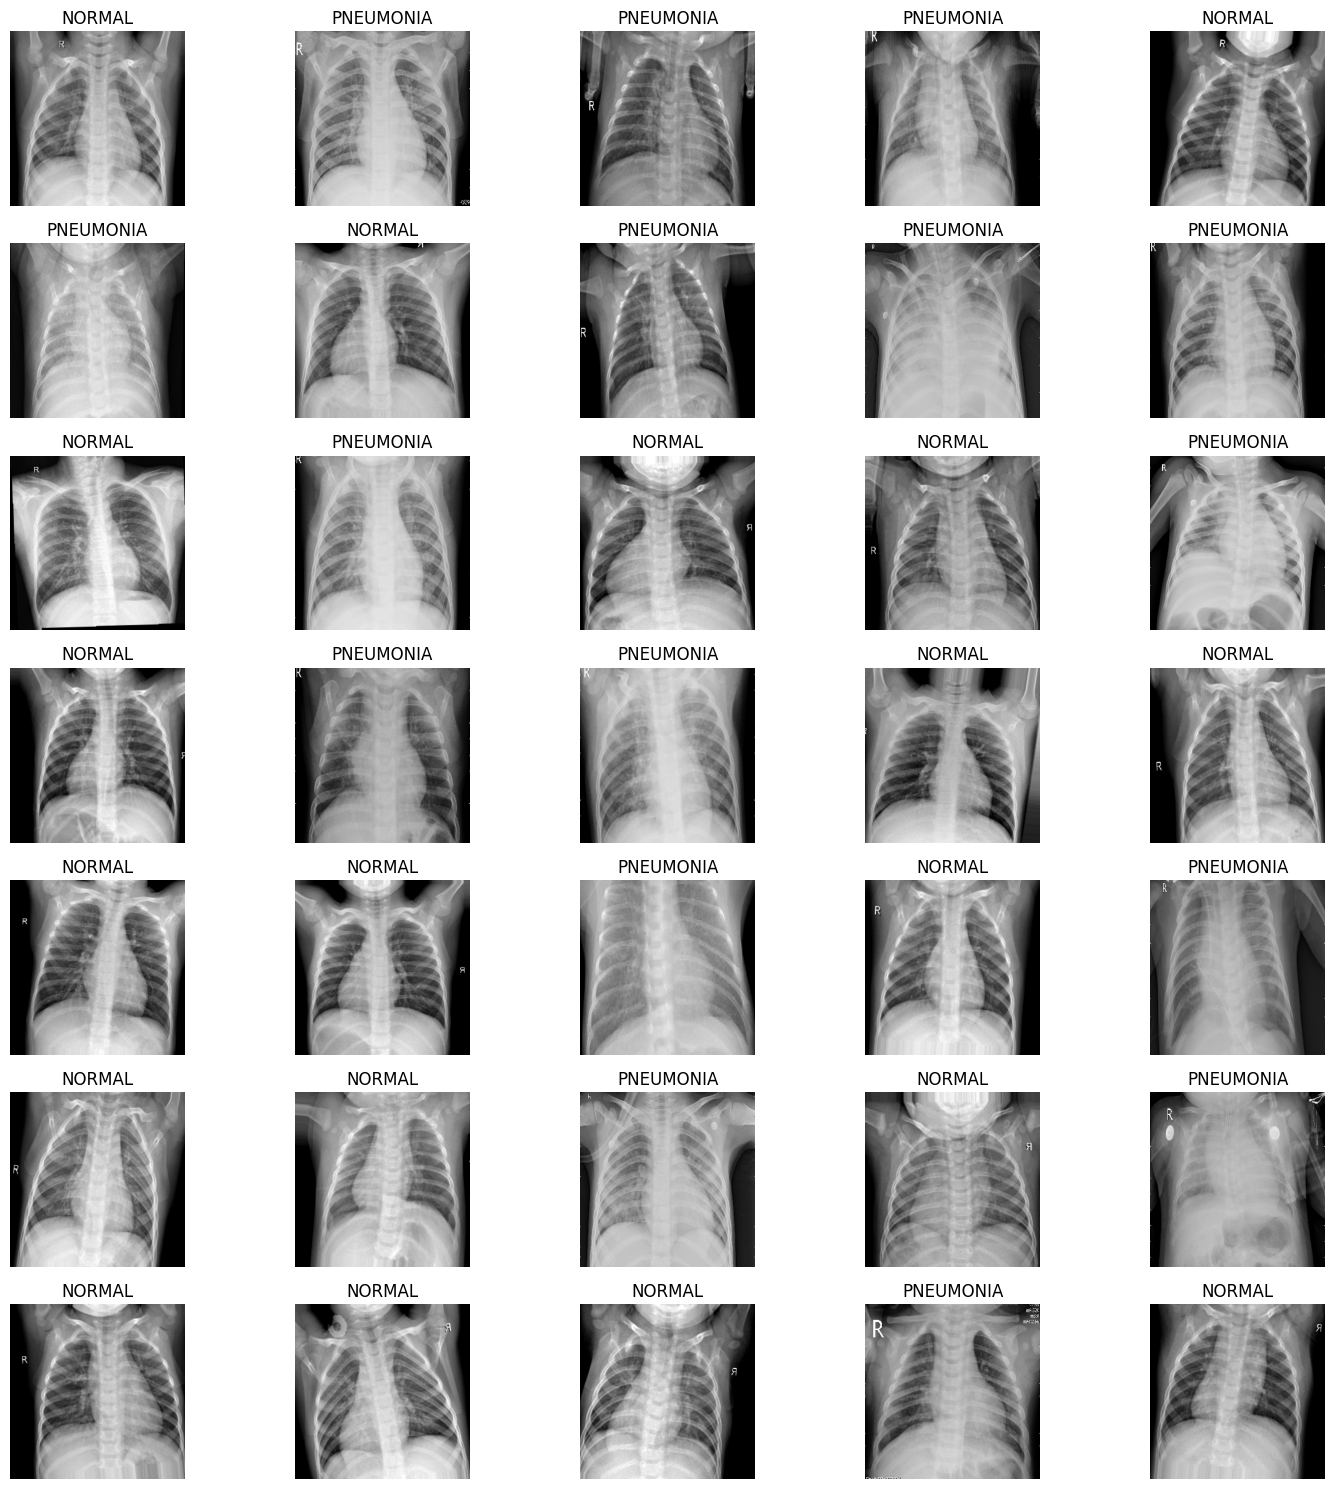

In [91]:
# Plot some images to ensure that the augmentation does NOT change the pics too much
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(15,15))
for i in range(35):
    img = x_batch[i].squeeze()
    label = 'NORMAL' if np.argmax(y_batch[i]) == 0 else 'PNEUMONIA'
    
    plt.subplot(7, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [92]:
 # as we are using custom generator and combing them it doesnt have .classes attribute which is used in computing class weights so we have to 
# compute class labels manually and then use them to compute classweights


normal_dir = os.path.join(new_train_dir, 'NORMAL')
pneumonia_dir = os.path.join(new_train_dir, 'PNEUMONIA')

num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

print(f"NORMAL: {num_normal}, PNEUMONIA: {num_pneumonia}")
import numpy as np
from sklearn.utils import class_weight

# 0 → NORMAL, 1 → PNEUMONIA
y_train_labels = [0] * num_normal + [1] * num_pneumonia
y_train_labels = np.array(y_train_labels)




NORMAL: 1167, PNEUMONIA: 3081


In [93]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train_labels),
    y = y_train_labels
    )
class_weight_dict = dict(enumerate(class_weights))
print("class weights:",class_weight_dict)

class weights: {0: 1.820051413881748, 1: 0.6893865628042843}


### **BUILDING A CUSTOM CNN MODEL**

In [94]:
# Build Model with Batch Normalization
cnn_model = Sequential([
    # Feature extraction
    Conv2D(16, (3, 3), padding='same', input_shape=(img_height, img_width, 1), kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(32, kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(2, activation='softmax')
])

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 320, 320, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 320, 320, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 320, 320, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 160, 160, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 160, 160, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     6,553,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,637,954 (25.32 MB)

 Trainable params: 6,637,474 (25.32 MB)

 Non-trainable params: 480 (1.88 KB)

In [95]:
# Compile Model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)
cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        restore_best_weights=True,
        min_delta=0.005
    ),
    ModelCheckpoint(
        'best_weights.keras',
        monitor='val_auc',  
        save_best_only=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]


`Custom CNN Model Architecture`

- Input: Grayscale images with shape (height, width, 1).
- Three convolutional blocks with Conv2D layers (16, 64, 128 filters), each followed by Batch Normalization, ReLU activation, and MaxPooling.
- Dropout (0.3) after the last convolution block for regularization.
- Flatten layer to convert 3D features to 1D vector.
- Dense layer with 32 units, L2 regularization, Batch Normalization, ReLU activation, and Dropout (0.5).
- Output layer with softmax function for categorical classification.
- Compiled with Adam optimizer, categorical cross-entropy loss, and accuracy metric.
- Callbacks include early stopping, model checkpointing (monitoring validation AUC), and learning rate reduction on plateau.


In [96]:
# Steps per epoch: total training samples // batch_size
steps_per_epoch = min(len(train_normal_generator), len(train_pneumonia_generator))
validation_steps = len(val_generator)
print(steps_per_epoch,validation_steps)

37 26


In [99]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = cnn_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # if categorical
# y_pred_classes = (y_pred > 0.5).astype("int32")  # if binary classification

y_true = val_generator.classes

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step
[[  0 212]
 [  0 595]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       212
           1       0.74      1.00      0.85       595

    accuracy                           0.74       807
   macro avg       0.37      0.50      0.42       807
weighted avg       0.54      0.74      0.63       807



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:

# Train model
history = cnn_model.fit(
    train_generator,  # your combined generator
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=cnn_callbacks,
    verbose=1
)
print("Training complete.")


Epoch 1/30


I0000 00:00:1752936745.267239     328 service.cc:148] XLA service 0x7949400074d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752936745.267932     328 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752936745.792973     328 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/37 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.6133 - auc: 0.6649 - loss: 0.8172 - precision: 0.6133 - recall: 0.6133 

I0000 00:00:1752936755.240087     328 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.8632 - auc: 0.9215 - loss: 0.3570 - precision: 0.8632 - recall: 0.8632

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8648 - auc: 0.9228 - loss: 0.3537 - precision: 0.8648 - recall: 0.8648 - val_accuracy: 0.7373 - val_auc: 0.8395 - val_loss: 0.5785 - val_precision: 0.7373 - val_recall: 0.7373 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 800ms/step - accuracy: 0.9770 - auc: 0.9960 - loss: 0.1237 - precision: 0.9770 - recall: 0.9770 - val_accuracy: 0.7373 - val_auc: 0.8310 - val_loss: 0.6548 - val_precision: 0.7373 - val_recall: 0.7373 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 816ms/step - accuracy: 0.9828 - auc: 0.9975 - loss: 0.0982 - precision: 0.9828 - recall: 0.9828 - val_accuracy: 0.7373 - val_auc: 0.8277 - val_loss: 0.7662 - val_precision: 0.7373 - val_recall: 0.7373 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9910 - auc: 0.9987 - loss: 0.0816 - precision: 0.9910 - recall: 0.9910
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873